In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
- Author(s) : Nima Hosseini Dashtbayaz
- Date: November 14th, 2022
- Title of ource code: Pinns
- Commit SHA: 3ff52aad08cb5315c4037824724240f43b336ab7
- Type: Python
- Repo URL: https://github.com/nimahsn/pinns.git
"""

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
from Modules.data import simulate_kdv
from Modules.models import KdvPinn
from Modules.plots import plot_kdv_model, plot_training_loss



2023-03-23 22:07:07.627000: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
k=6
c= 7
phi = 0
def phi_function(tx):
    # offset =  -4*np.pi
    offset = 8
    return c / (2*tf.cosh(np.sqrt(c)*(tx[:, 1:2]+offset)/2)**2)+phi
    

def boundary_function(tx):
    return phi*tf.ones_like(tx[:, 1:])

# x_start = 0
# length = 8*np.pi
# time =  np.pi/2

x_start = -20
length = 20
time = 7.5


In [25]:
## execute this cell for two-soliton solution

k=6
# c=5
c1 = 3.25 
c2 = 0.5
print(c1/c2)
phi = 0
def phi_function(tx):
    offset = 0
    ksi1 = tx[:, 1:2] - c1*tx[:, 0:1] -1
    ksi2 = tx[:, 1:2] - c2*tx[:, 0:1] + offset
    exact = 2*(c1-c2) * (c1*tf.cosh(np.sqrt(c2)*(ksi2)/2)**2 + c2* (tf.sinh(np.sqrt(c1)*(ksi1)/2)**2))/ ((np.sqrt(c1)-np.sqrt(c2)) * tf.cosh((np.sqrt(c1) * ksi1 +np.sqrt(c2)* ksi2)/2) +  (np.sqrt(c1)+np.sqrt(c2)) * tf.cosh((np.sqrt(c1)*ksi1-np.sqrt(c2)*ksi2)/2))**2
    return exact
    

def boundary_function(tx):
    return phi*tf.ones_like(tx[:, 1:])

x_start = -25
length = 25
time = 4.5

6.5


In [26]:
#(tx_samples, y_samples), (tx_init, y_init), (tx_boundary,y_boundary) = simulate_kdv(1000, f_init,boundary_function, x_start, length, time)
(tx_eqn, y_eqn), (tx_init, y_init), (tx_boundary, y_boundary) = simulate_kdv(1000, phi_function, boundary_function, length, time, x_start,random_seed = 42, dtype=tf.float32) 
network = KdvPinn.build_network([32, 64])
model = KdvPinn(network)
model.compile()



In [14]:
num = 200
t_flat = np.linspace(0, time, num)
x_flat = np.linspace(x_start, length, num)
t, x = np.meshgrid(t_flat, x_flat)

tx = np.stack([t.flatten(), x.flatten()], axis=-1)
tx = np.stack([np.full(t_flat.shape, 4), x_flat], axis=-1)
# u = model.network.predict(tx, batch_size=num)
tx = tf.convert_to_tensor(tx)
soln = phi_function(tx)

In [20]:
# soln= soln.numpy().reshape(num,-1)
print(tx.shape)

(200, 2)


In [8]:

plt.plot(tx[:,1:2],soln,'.')
print(max(phi_function(tx_init)))

NameError: name 'tx' is not defined

In [27]:
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=1000, decay_rate=0.7)
inputs = tf.stack([tx_eqn, tx_init, tx_boundary], axis=0)
outputs = tf.stack([y_init, y_boundary], axis=0)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


In [30]:

history = model.fit(inputs, outputs, 2000, optimizer, progress_interval=200)



Epoch: 0 Loss: 0.0003 Total Elapsed Time: 0.11
Epoch: 200 Loss: 0.0002 Total Elapsed Time: 31.73
Epoch: 400 Loss: 0.0002 Total Elapsed Time: 55.79
Epoch: 600 Loss: 0.0002 Total Elapsed Time: 80.76
Epoch: 800 Loss: 0.0002 Total Elapsed Time: 106.08
Epoch: 1000 Loss: 0.0002 Total Elapsed Time: 132.41
Epoch: 1200 Loss: 0.0002 Total Elapsed Time: 158.95
Epoch: 1400 Loss: 0.0002 Total Elapsed Time: 182.70
Epoch: 1600 Loss: 0.0002 Total Elapsed Time: 215.21
Epoch: 1800 Loss: 0.0002 Total Elapsed Time: 242.39


1/1 [==============================] - 0s 250ms/step


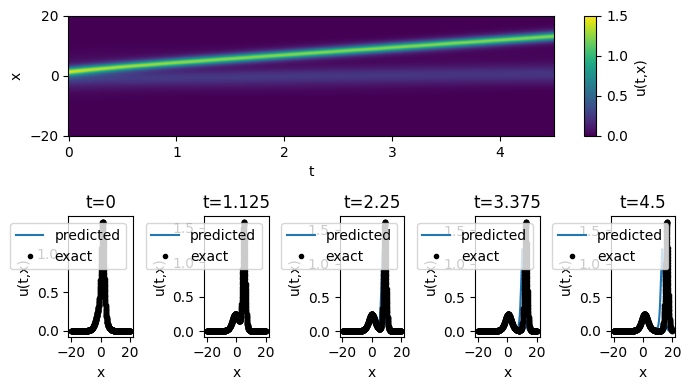

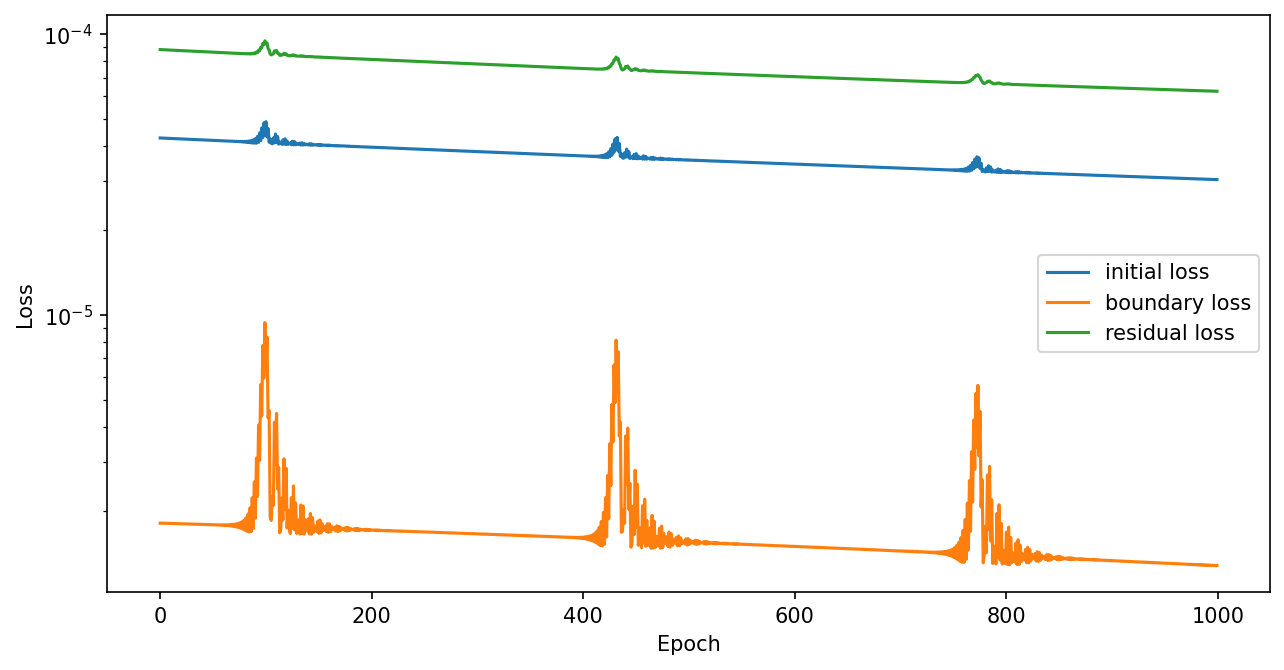

In [22]:
plot_kdv_model(model.network, x_start, length, time,0,1.5,phi_function)

plot_training_loss(history, y_scale='log')

1/1 [==============================] - 0s 272ms/step


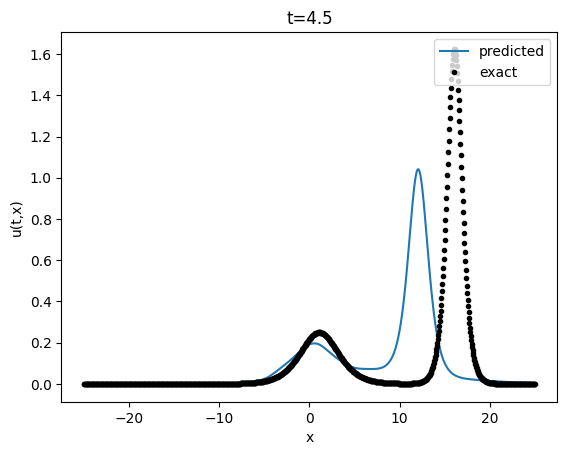

In [31]:
num_test_samples = 1000
t_flat = np.linspace(0, time, num_test_samples)
x_flat = np.linspace(x_start, length, num_test_samples)
t, x = np.meshgrid(t_flat, x_flat)
tx = np.stack([t.flatten(), x.flatten()], axis=-1)

t_cross_sections = [2.25] # put time here
for i, t_cs in enumerate(t_cross_sections):
    tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
    u = model.network.predict(tx, batch_size=num_test_samples)
    
    plt.plot(x_flat, u,label='predicted')

    u_exact = phi_function(tx)
    plt.plot(x_flat,u_exact,'k.',label='exact')
    plt.title('t={}'.format(np.round(t_cs,3)))
    plt.xlabel('x')
    plt.ylabel('u(t,x)')
    plt.legend(loc='upper right')
plt.show()

1/1 [==============================] - 0s 86ms/step


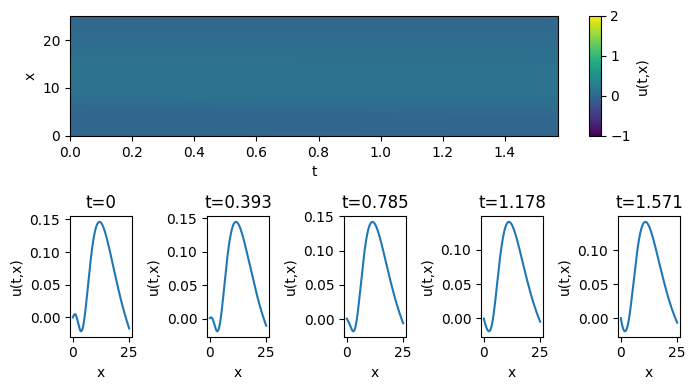

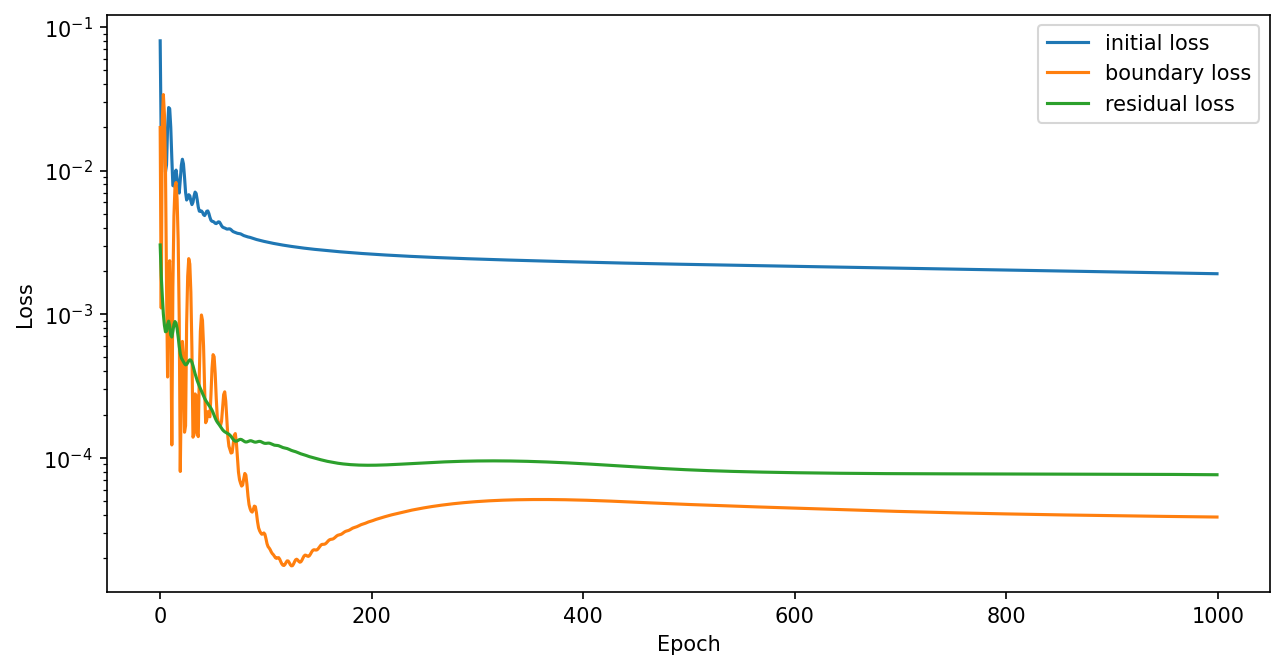

In [11]:
plot_kdv_model(model1.network, x_start, length, time)

plot_training_loss(histories[0], y_scale='log')

1/1 [==============================] - 0s 73ms/step


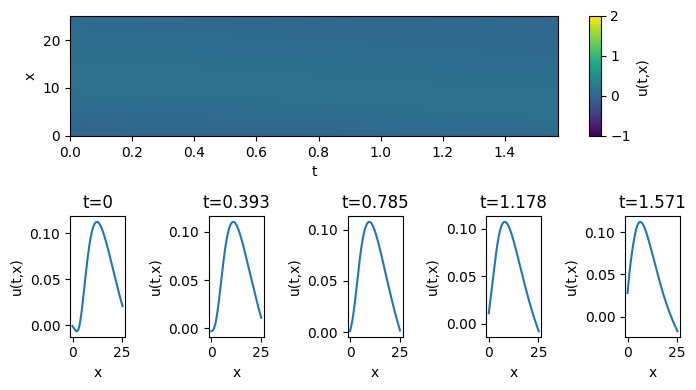

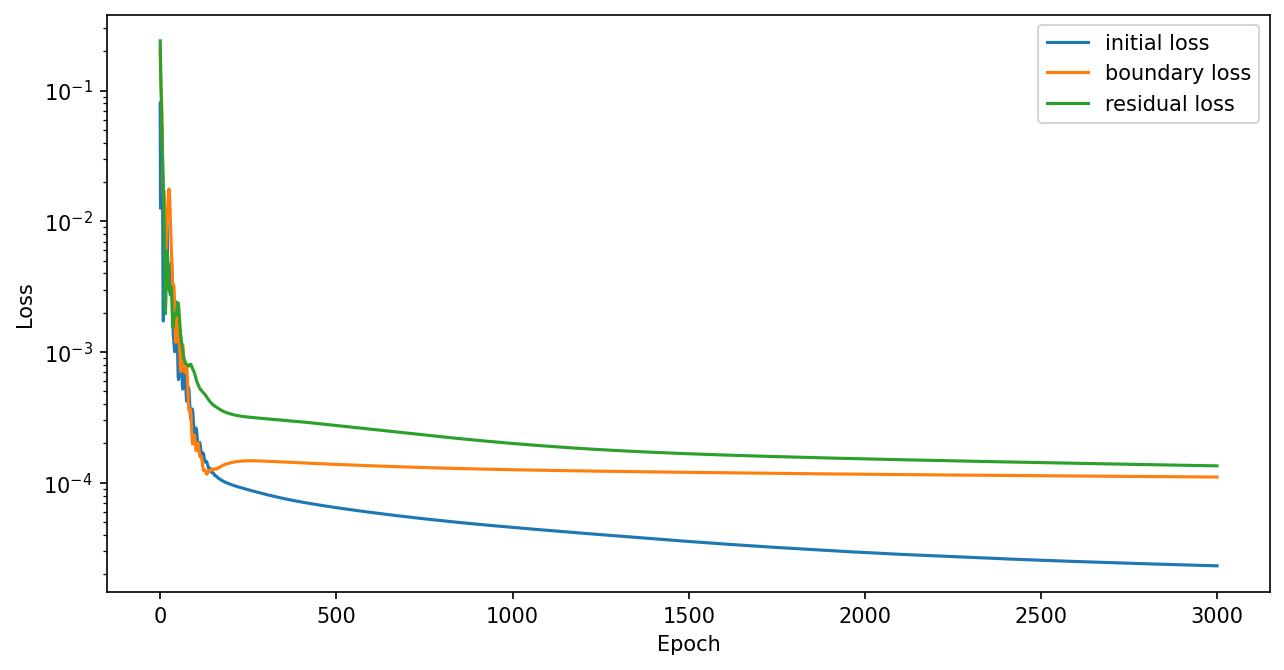

In [12]:
plot_kdv_model(model5.network, x_start, length, time)

plot_training_loss(histories[4], y_scale='log')

In [ ]:
plot_kdv_model(model1.network, x_start, length, time)

plot_training_loss(history, y_scale='log')

In [8]:
network1 = KdvPinn.build_network([32, 64])
network2 = KdvPinn.build_network([32, 64])
network3 = KdvPinn.build_network([32, 64])
network4 = KdvPinn.build_network([32, 64])
network5 = KdvPinn.build_network([32, 64])
model1 = KdvPinn(network1,6,1)
model1.compile()
model2 = KdvPinn(network2,6,2)
model2.compile()
model3 = KdvPinn(network3,6,3)
model3.compile()
model4 = KdvPinn(network4,6,4)
model4.compile()
model5 = KdvPinn(network5,6,5)
model5.compile()

In [9]:
models = [model1,model2,model3,model4,model5]


In [10]:
y_init = phi_function(tx_init)
histories = []
ii = 0
for m in models:
    print('model:', ii+1)
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=1000, decay_rate=0.7)
    inputs = tf.stack([tx_eqn, tx_init, tx_boundary], axis=0)
    outputs = tf.stack([y_init, y_boundary], axis=0)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    epochs = (ii)*500 + 1000
    history = m.fit(inputs, outputs, epochs, optimizer, progress_interval=200)
    histories.append(history)
    y_init = m.network(tx_init)
    ii += 1



model: 1
Epoch: 0 Loss: 0.1031 Total Elapsed Time: 10.14
Epoch: 200 Loss: 0.0027 Total Elapsed Time: 40.64
Epoch: 400 Loss: 0.0024 Total Elapsed Time: 69.00
Epoch: 600 Loss: 0.0023 Total Elapsed Time: 94.27
Epoch: 800 Loss: 0.0021 Total Elapsed Time: 120.81
model: 2
Epoch: 0 Loss: 0.6179 Total Elapsed Time: 9.82
Epoch: 200 Loss: 0.0010 Total Elapsed Time: 36.75
Epoch: 400 Loss: 0.0006 Total Elapsed Time: 62.17
Epoch: 600 Loss: 0.0005 Total Elapsed Time: 86.88
Epoch: 800 Loss: 0.0004 Total Elapsed Time: 113.50
Epoch: 1000 Loss: 0.0003 Total Elapsed Time: 140.24
Epoch: 1200 Loss: 0.0003 Total Elapsed Time: 174.96
Epoch: 1400 Loss: 0.0003 Total Elapsed Time: 203.90
model: 3
Epoch: 0 Loss: 0.2769 Total Elapsed Time: 11.65
Epoch: 200 Loss: 0.0006 Total Elapsed Time: 45.17
Epoch: 400 Loss: 0.0003 Total Elapsed Time: 73.88
Epoch: 600 Loss: 0.0003 Total Elapsed Time: 103.04
Epoch: 800 Loss: 0.0002 Total Elapsed Time: 130.02
Epoch: 1000 Loss: 0.0002 Total Elapsed Time: 157.95
Epoch: 1200 Loss: 

In [7]:
num = 50
t_flat = np.linspace(0, time, num)
x_flat = np.linspace(0, length, num)
t, x = np.meshgrid(t_flat, x_flat)

tx = np.stack([t.flatten(), x.flatten()], axis=-1)

# u = model.network.predict(tx, batch_size=num)
tx = tf.convert_to_tensor(tx)

In [8]:
# with tf.GradientTape(watch_accessed_variables=False) as g5:
#     g5.watch(tx)
with tf.GradientTape(watch_accessed_variables=False) as g4:
    g4.watch(tx)
    with tf.GradientTape(watch_accessed_variables=False) as ggg:
        ggg.watch(tx)
        with tf.GradientTape(watch_accessed_variables=False) as gg:
            gg.watch(tx)
            with tf.GradientTape(watch_accessed_variables=False) as g:
                g.watch(tx)
                u = model.network(tx)

            first_order = g.batch_jacobian(u, tx)
            du_dt = first_order[..., 0]
            du_dx = first_order[..., 1]

        d2u_dx2 = gg.batch_jacobian(du_dx, tx)[..., 1]
    d3u_dx3 = ggg.batch_jacobian(d2u_dx2, tx)[..., 1]
d4u_dx4 = g4.batch_jacobian(d3u_dx3, tx)[..., 1]
# d5u_dx5 = g5.batch_jacobian(d4u_dx4, tx)[..., 1]

In [9]:
print(du_dx.shape)
du_dx = du_dx.numpy().reshape(num,-1)
print(du_dx.shape)

print(du_dt.shape)
du_dt = du_dt.numpy().reshape(num,-1)
print(du_dt.shape)

print(d2u_dx2.shape)
d2u_dx2 = d2u_dx2.numpy().reshape(num,-1)
print(d2u_dx2.shape)

print(d3u_dx3.shape)
d3u_dx3 = d3u_dx3.numpy().reshape(num,-1)
print(d3u_dx3.shape)




(2500, 1)
(50, 50)
(2500, 1)
(50, 50)
(2500, 1)
(50, 50)
(2500, 1)
(50, 50)


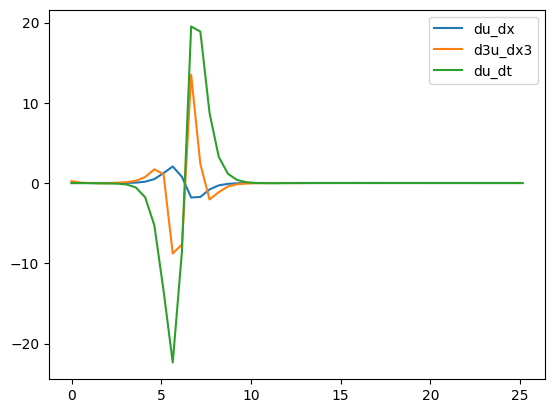

In [17]:
tt= 0
plt.plot(x_flat, du_dx[:,tt],label='du_dx')
plt.plot(x_flat, d3u_dx3[:,tt],label='d3u_dx3')
plt.plot(x_flat, du_dt[:,tt],label='du_dt')
plt.legend()

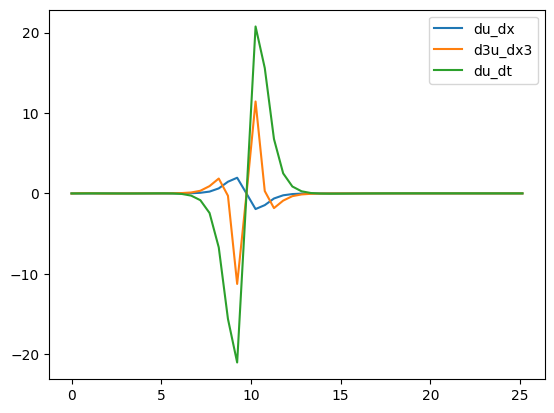

In [15]:
tt= 10
plt.plot(x_flat, du_dx[:,tt],label='du_dx')
plt.plot(x_flat, d3u_dx3[:,tt],label='d3u_dx3')
plt.plot(x_flat, du_dt[:,tt],label='du_dt')
plt.legend()


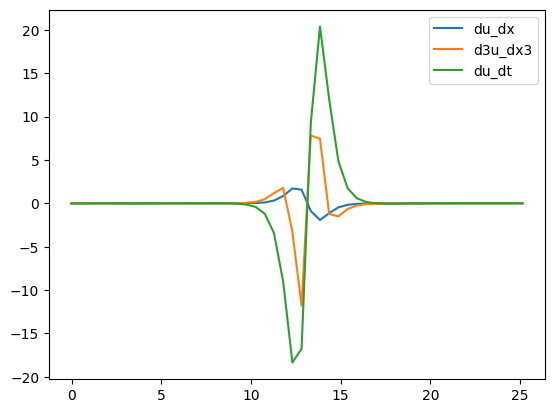

In [16]:
tt= 20
plt.plot(x_flat, du_dx[:,tt],label='du_dx')
plt.plot(x_flat, d3u_dx3[:,tt],label='d3u_dx3')
plt.plot(x_flat, du_dt[:,tt],label='du_dt')
plt.legend()

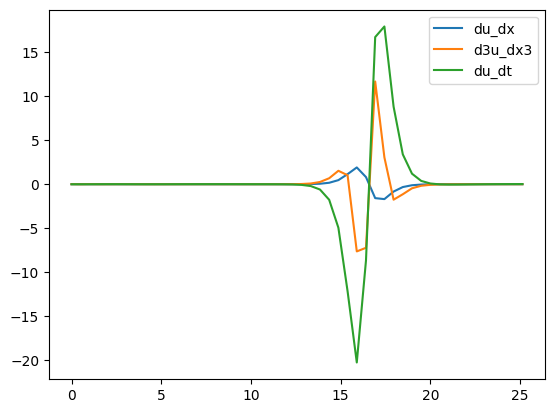

In [18]:
tt= 30
plt.plot(x_flat, du_dx[:,tt],label='du_dx')
plt.plot(x_flat, d3u_dx3[:,tt],label='d3u_dx3')
plt.plot(x_flat, du_dt[:,tt],label='du_dt')
plt.legend()

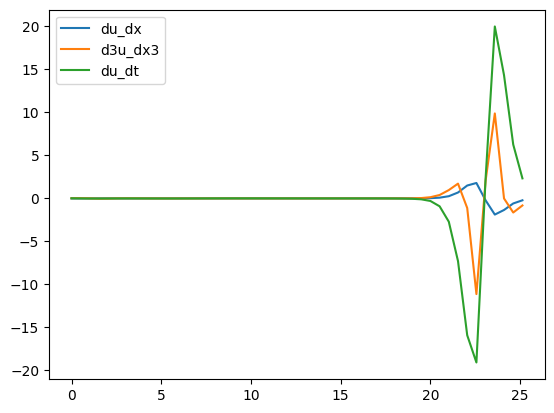

In [19]:
tt= 49
plt.plot(x_flat, du_dx[:,tt],label='du_dx')
plt.plot(x_flat, d3u_dx3[:,tt],label='d3u_dx3')
plt.plot(x_flat, du_dt[:,tt],label='du_dt')
plt.legend()

In [49]:
np.round(0.009,2)

0.01

In [77]:
list = []
list.append(model)

<class 'Modules.models.KdvPinn'>
